# Final report, v-AMOS Team

## Table of Content
- [Introduction](#introduction)
- [Data Model](#data-model)
- [Additional Classes](#additional-classes)
    - [Relational Processor](#relational-processor)
    - [Triplestore Processor](#triplestore-processor)
    - [Generic Query Processor](#generic-query-processor)
- [Descriptive Statistics](#descriptive-statistics)
- [Statements of Responsibility](#statements-of-responsibility)

## Introduction
The following notebook is intended as a report for the final project of the course "Data Science" (Prof. Peroni), consisting of a Python query processor for graph and relational databases. It was developed by the team "v-AMOS", composed by four students of the MA "Digital Humanities and Digital Humanities" at University of Bologna: [Amelia Lamargese](mailto:amelia.lamargese@studio.unibo.it), [Olga Pagnotta](mailto:olga.pagnotta@studio.unibo.it), [Manuele Veggi](mailto:manuele.veggi@studio.unibo.it) e [Sara Vellone](mailto:sara.vellone@studio.unibo.it).

The specific guidelines of the project are available at the following [page](https://github.com/comp-data/2021-2022/tree/main/docs/project).

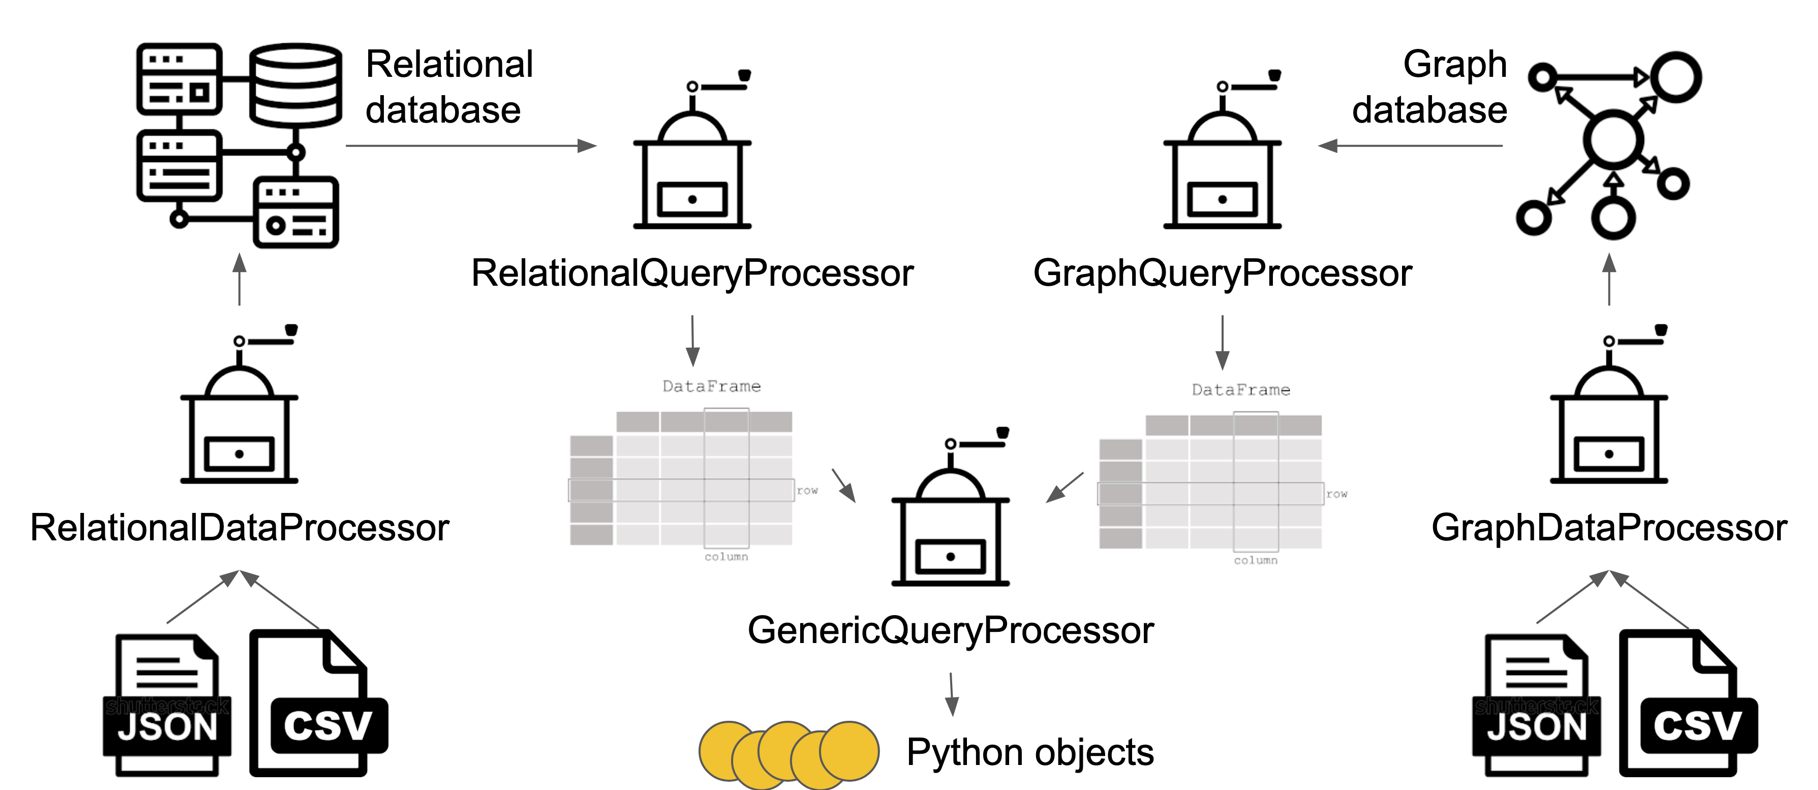

## Data Model

The databases contain information about different academic publications. The entirety of the pieces of information provided can be organized within a data model and graphically visualized through UML.

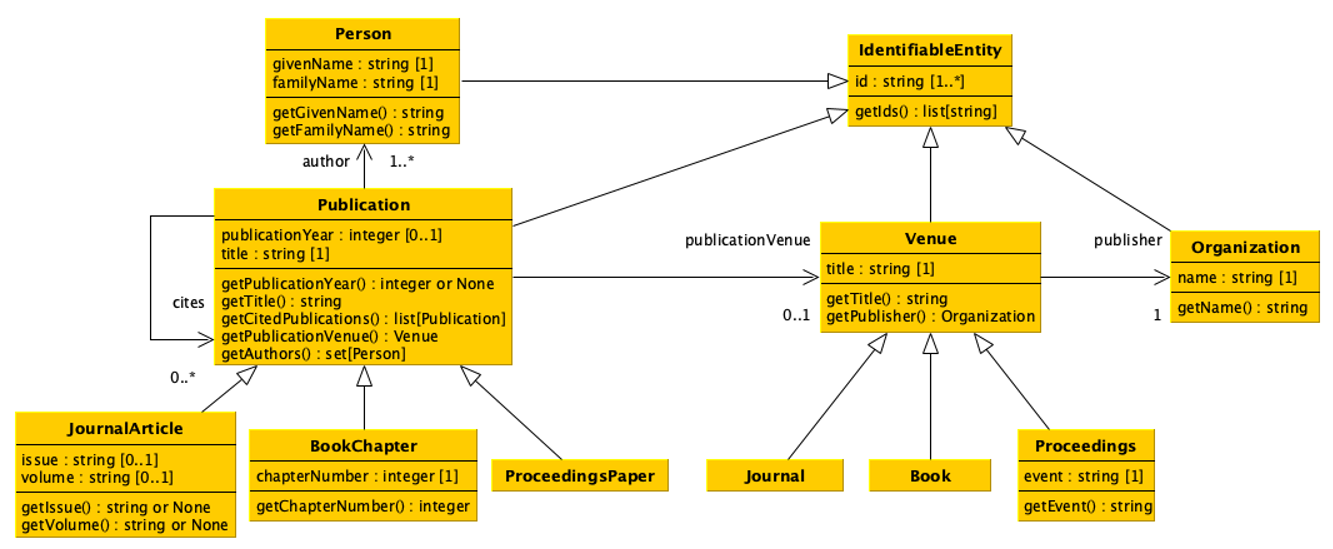

One of the first tasks hence concerned the translation of the model into a proper Python code. Following the syntax of classes declaration, we started defining properties and methods of *IdentifiableEntity*, as all the other classes are its subclasses. 

In [1]:
class IdentifiableEntity:
    def __init__(self, identifier):
        self.identifier = identifier

    def getIds(self):
        return list(self.identifier)

Later on, we proceeded with the subclasses *Person* and *Organization*:

In [2]:
class Person(IdentifiableEntity):
    def __init__(self, identifier, givenName, familyName):
        super().__init__(identifier)
        self.givenName = givenName
        self.familyName = familyName

    def getGivenName(self):
        return self.givenName

    def getFamilyName(self):
        return self.familyName


class Organization(IdentifiableEntity):
    def __init__(self, identifier, name):
        super().__init__(identifier)
        self.name = name

    def getName(self):
        return self.name

We also defined *Publication* and its subclasses (*JournalArticle*, *BookChapter*, *ProceedingsPaper*).

In [3]:
class Publication(IdentifiableEntity):
    def __init__(self, identifier, publicationYear, title, cited, authors, publicationVenue):
        super().__init__(identifier)
        self.publicationYear = publicationYear
        self.title = title
        self.cited = cited
        self.authors = authors
        self.publicationVenue = publicationVenue

    def getPublicationYear(self):
        return self.publicationYear

    def getTitle(self):
        return self.title

    def getCitedPublications(self):
        return self.cited 

    def getPublicationVenue(self):
        return self.publicationVenue

    def getAuthors(self):
        return self.authors  


class JournalArticle(Publication):
    def __init__(self, identifier, publicationYear, title, cited, authors, publicationVenue, issue, volume):
        super().__init__(identifier, publicationYear, title, cited, authors, publicationVenue)
        self.issue = issue
        self.volume = volume

    def getIssue(self):
        return self.issue

    def getVolume(self):
        return self.volume


class BookChapter(Publication):
    def __init__(self, identifier, publicationYear, title, cited, authors, publicationVenue, chapterNumber):
        super().__init__(identifier, publicationYear, title, cited, authors, publicationVenue)
        self.chapterNumber = chapterNumber

    def getChapterNumber(self):
        return self.chapterNumber


class ProceedingsPaper(Publication):
    pass

Lastly, we declared *Venue* and the subclasses *Journal*, *Book* and *Proceedings*.

In [4]:
class Venue(IdentifiableEntity):
    def __init__(self, identifier, title, publisher):
        super().__init__(identifier)
        self.title = title
        self.publisher = publisher

    def getTitle(self):
        return self.title

    def getPublisher(self):
        return self.publisher


class Journal(Venue):
    pass


class Book(Venue):
    pass


class Proceedings(Venue):
    def __init__(self, identifier, title, publisher, event):
        super().__init__(identifier, title, publisher)
        self.event = event

    def getEvent(self):
        return self.event

For the classes *Publication*, *JournalArticle*, *Venue*, *Proceedings*, *Person* and *Organization*, the additional method *.__str__()* has been provided, in order to allow the visualization of their attributes in the output of the Generic Query Processor's queries. The method creates and returns a list in which the attributes are converted into strings and labeled. Follows, as an example, the method *.__str__()* of the class *Publication*:

In [5]:
def __str__(self): 
        result = list()
        result.append('Publication:')
        result.append(str(self.identifier))
        result.append('publication year: ' + str(self.publicationYear))
        result.append('title: ' + str(self.title))
        result.append('authors: ' + str(self.authors))
        result.append('publication venue: ' + str(self.publicationVenue))
        if len(self.cited) > 0:
            result.append('cited publications:' + str('\n'.join(self.cited)))
        else:
            result.append('cited publications: None')

        return '\n'.join(result)

## Additional classes

The classes defining the functioning of the query processor have been described in the following UML model:

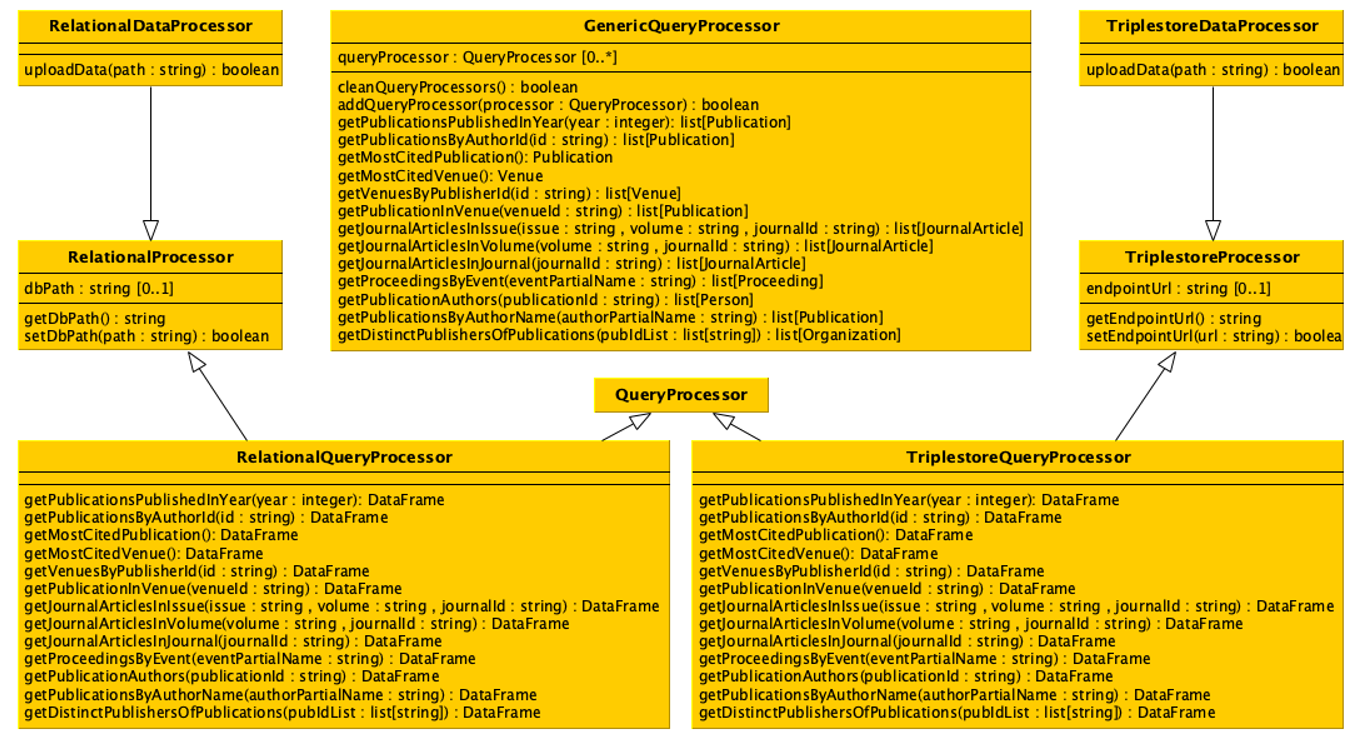

To complete the translation in Python, the workload was split into two halves: firstly, the creation and the query software for the relational database was created, then the same functionalities were adapted to the graph database. 

### Relational Processor

The relational database is handled by the the class **RelationalProcessor** (defined in `relationalProcessorClasses.py`) and its two subclasses, *RelationalDataProcessor* and *RelationalProcessor*. The former is defined through file path (below mentioned as `dbPath`) and by the two methods `getdbPath` and `setdbPath`*` and has been defined as follows:

In [6]:
class RelationalProcessor:
    def __init__(self, dbPath):
        self.dbPath = dbPath

    def getDbPath(self):  
        return self.dbPath

    def setDbPath(self, path):
        if path != '': 
            self.dbPath = path
            return True 
        else:
            return False

The subclass **RelationalDataProcessor** is encharged of the creation of the database starting from the two input files. Given that these two inputs can be either in CSV or JSON format, the method *uploadData* needs to be modeled in two halves, one of each focused on the treatment of a specific file format. 

The following schema describes the construction of the relational database, whose semantics is defined by two different chromatic legendas, expressing:
- File format: yellow for dataframes populated with data provided by the JSON file and red if the data are stored in the CSV file.
- Classes: the coloured headers allow to create connections between these dataframes and the four main classes (and some of its subclasses) of the [data model](#data-model), namely "Person" (in orange), "Publication" (in blue), "Venue" (in magenta) and "Organization" (in green). Not all the subclasses are represented: indeed, we focused exclusively on the ones which are necessary to properly answer the queries proposed by the methods of the `RelationalQueryProcessor`. The joining of the table is indeed possible thanks to official unique identifier, i.e. doi for publications, orcid for authors, issn/isbn for venues and crossref for publishers. 

Finally, the highlighted columns (black box) and the dashed lines highlight the connections between the different dataframes: this link will be translated by the statement `JOIN` of the SQL syntax. 

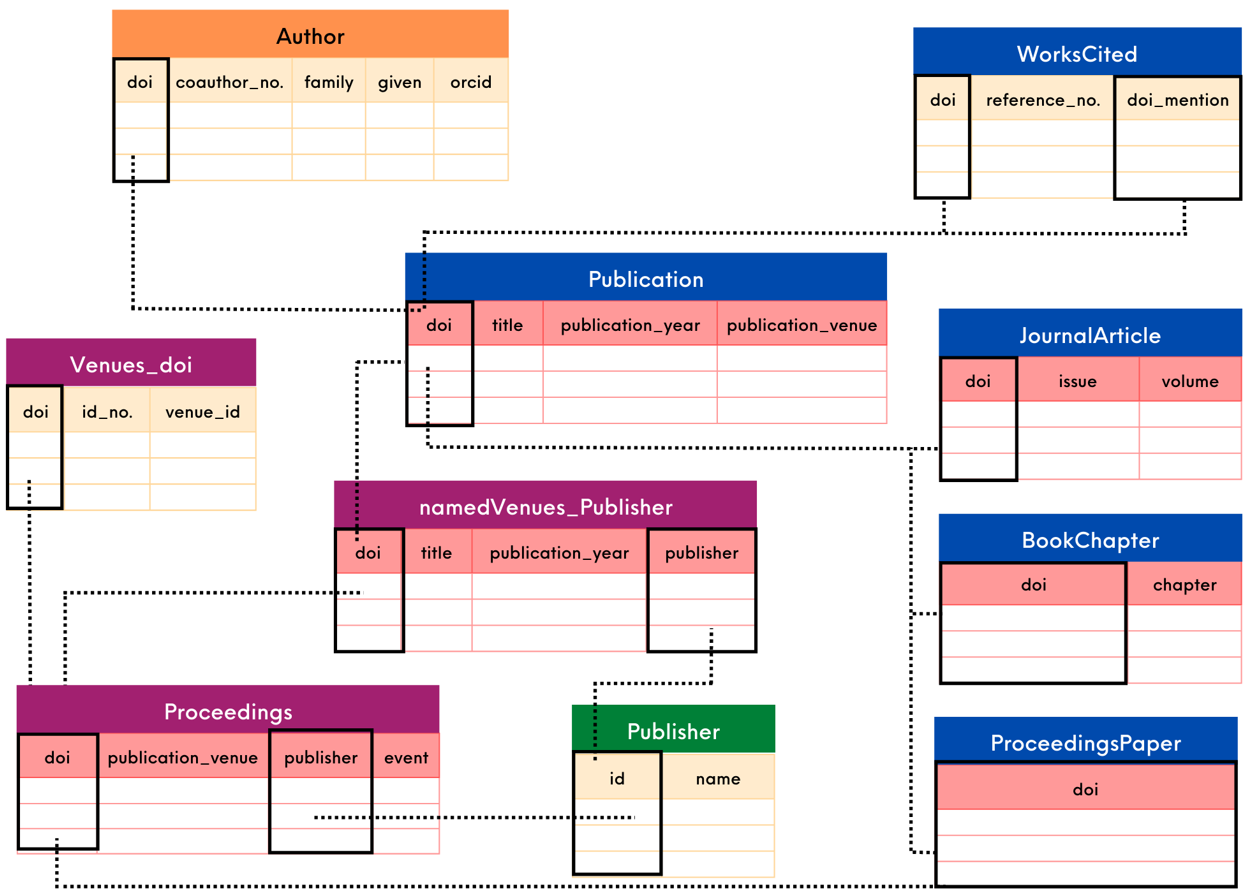

The method `uploadData` reflects the duplicity of the formats of the two inputs file, as it is structured by means of a `if` and `elif`statement. The creation of the dataframes starting from CSV file was quite simple as it consisted in a fragmentation of the orginal table, created with the function `pd.read_csv(...)`. 

On the contrary, the complex and nested structure of the sample JSON file was simplified thanks to the four main keys (`"authors"`, `"venues_id"`, `"references"` and `"publishers"`), which allow to create four distinct dataframes. Each table has been later populated with an *ad hoc* algorithm, able to take into account the peculiarities of the considered dataset. 

In [7]:
from json import load
import pandas as pd
from pandas import read_csv, read_sql, DataFrame
from sqlite3 import connect

class RelationalDataProcessor(RelationalProcessor):
    def __init__(self, dbPath):
      super().__init__(dbPath)

    def uploadData(self, path):
        if path != '': 
            if  path.endswith(".json"):           
                with open(path, "r", encoding="utf-8") as f:
                    jsonData = load(f)

                    # lines 30-82 omitted: creation of the dataframes

                with connect(self.dbPath) as con:
                    authorDf.to_sql("Author", con, if_exists="replace", index=False)        
                    publisherDf.to_sql("Publisher", con, if_exists="replace", index=False)
                    referencesdDf.to_sql("WorksCited", con, if_exists="replace", index=False)
                    venueDoi.to_sql("Venues_doi", con, if_exists="replace", index=False)
                    con.commit()
                return True

            if  path.endswith(".csv"):                
                csvData = pd.read_csv(path)

                # lines 93-119 omitted: creation of the dataframes

                with connect(self.dbPath) as con:
                    publication.to_sql("Publication", con, if_exists="replace", index=False)
                    journal_articles.to_sql("JournalArticles", con, if_exists="replace", index=False)
                    book_chapter.to_sql("BookChapter", con, if_exists="replace", index=False)
                    proceedings_paper.to_sql("ProceedingsPaper", con, if_exists="replace", index=False)
                    venueNamesPub.to_sql("namedVenues_Publisher", con, if_exists="replace", index=False)
                    proceedings.to_sql("Proceedings", con, if_exists="replace", index=False)
                    con.commit()
                return True
            else:
                return False
        else:
            return False

Lastly, in the **RelationalQueryProcessor** all the queries have been defined. All the queries follow (with specific integrations where necessary) a bipartite section:
1. Definition of the query as a string in SQL syntax. Before the incorporation in the Python file, each query has been directly tested on the database through the tab "Exectue SQL" on the software "DB Browser for SQLite".  
2. Creation of the output dataframe through the function `pd.read_sql(..., ...)`

For instance, the method `getPublicationsPublishedInYear` is structured as follows:

In [8]:
def getPublicationsPublishedInYear(self, year):
        with connect(self.dbPath) as con:  
            query = """ 
            SELECT Author.orcid, Author.given, Author.family,  Publication.title, Author.doi, Publication.publication_venue, namedVenues_Publisher."publisher", Publication.publication_year
            FROM Publication
            LEFT JOIN Author ON Publication.doi == Author.doi
            LEFT JOIN namedVenues_Publisher ON namedVenues_Publisher.doi == Publication.doi
            WHERE Publication.publication_year = '{0}';""".format(year)
            df_sql = read_sql(query, con)
            return df_sql

If the user wants to retrieve all the publications published in year 2020, it is sufficient to call the function with the argument. The output will be:

In [ ]:
1) getPublicationsPublishedInYear:
                    orcid            given      family  ...                     publication_venue     publisher publication_year
0    0000-0003-0530-4305           Silvio      Peroni  ...          Quantitative Science Studies  crossref:281             2020
1    0000-0001-5506-523X            David     Shotton  ...          Quantitative Science Studies  crossref:281             2020
2    0000-0002-7958-9924            Paolo  Ciancarini  ...                        Scientometrics  crossref:297             2020
3    0000-0001-5568-2684             Aldo     Gangemi  ...                        Scientometrics  crossref:297             2020
4    0000-0003-2928-9496  Andrea Giovanni   Nuzzolese  ...                        Scientometrics  crossref:297             2020
..                   ...              ...         ...  ...                                   ...           ...              ...
131  0000-0001-7600-8656            David      Urbano  ...  Journal Of Small Business Management  crossref:301             2020
132  0000-0002-9804-7813     Luísa Cagica    Carvalho  ...           Management Review Quarterly  crossref:297             2020
133  0000-0003-1722-6148       Maria José     Madeira  ...           Management Review Quarterly  crossref:297             2020
134  0000-0002-9703-1481   Lurdes Barroso       Simao  ...           Management Review Quarterly  crossref:297             2020
135  0000-0002-8912-5760            Imran         Ali  ...            Accountability In Research  crossref:301             2020

[136 rows x 8 columns]

The provided sample database has also been changed to test the method `getProceedingsByEvent`. These changes have been implemented on two temporary fictious files (namely, *relational_publications2.csv* and *relationalJSON2.json*) and allowed to test the following function.

In [ ]:
def getProceedingsByEvent(self, eventPartialName):
        with connect(self.dbPath) as con:
            query = """
            SELECT Proceedings.publication_venue , Venues_doi.venue_id, Proceedings.publisher
            FROM Proceedings 
            LEFT JOIN Venues_doi ON Venues_doi.doi == Proceedings.doi
            WHERE Proceedings.event COLLATE SQL_Latin1_General_CP1_CI_AS LIKE '%{0}%' """.format(eventPartialName)
            df_sql = read_sql(query, con)
            return df_sql

Lastly, an additional method was created, which was not mentioned in the original data model. `getCitedPublications` retrieves all the publications mentioned by another publication, individuated by its doi, as shown by the block below.

In [ ]:
def getCitedPublication(self, doi):
        with connect(self.dbPath) as con: 
            query = """ SELECT doi_mention
            FROM WorksCited
            WHERE doi = "{0}";""".format(doi)
            worksCited = read_sql(query, con)
            output = pd.DataFrame()
            for label, content in worksCited.iteritems():
                for doiCited in content:
                    query = """ SELECT Author.doi, Author.orcid, Author.given, Author.family,  Publication.title,  Publication.publication_venue, namedVenues_Publisher."publisher", Publication.publication_year
                    FROM Publication
                    LEFT JOIN Author ON Publication.doi == Author.doi
                    LEFT JOIN namedVenues_Publisher ON namedVenues_Publisher.doi == Publication.doi
                    WHERE Publication.doi = '{0}';""".format(doiCited)
                    df_sql = read_sql(query, con)
                    output = pd.concat([output, df_sql])
            return output

### Triplestore Processor

For what concerns the Graph Database, we have populated a Triplestore Database, in order to store and retrieve RDF triples. We have used Blazegraph, a high performance graph database, suitable for RDF triples. 

The file named `triplestoreProcessorClasses.py` contains all the information regarding this database.

The first step for the creation of the data base has been the definition of the variables, which were then used for the creation of the triples: subject, predicate, object.

In [ ]:
base_url = "https://github.com/olgagolgan/v-AMOS"

As from the code above, the first variable defined is the base URL, which has been used, in the next steps, to create the common basis for the subject of the triples, enriched, in the various triples, by a significant ID regarding the specific info dealt in the triple, as in the following example, where the "local_id" corresponds to the DOI of the specific publication taken into consideration:

In [ ]:
 for idx, row in table.iterrows():
    local_id = row["id"]
    subj = URIRef(base_url + "/" + local_id)

The next variables being defined are the specific classes of the UML data model provided above: JournalArticle, BookChapter, Journal and Book. They have been associated to a meaninful URI taken from the schema.org ontology, describing their features. For example, the JournalArticle has been defined by means of the schema.org property "ScholarlyArticle", being it the nearest to the articles in our dataset:

In [ ]:
JournalArticle = URIRef("https://schema.org/ScholarlyArticle")

For what concerns the attributes of the various classes, some properties taken from schema.org have been chosen, in order to be at the same time the most specific and uniquely identifiable for every variable. For example, there are present four different kinds of ID: doi, identifier, orcid, venueID. For each of them, a meaningful property has been chosen. For the doi, the property "https://schema.org/productID" has been chosen, for the characteristics desrcibed in the schema.org ontology, thus identifying a product, as a publication. For the generic identifier attribute, we decided to use the schema.org "https://schema.org/identifier" property, as associate it, in the triples, to the publisher id. For the orcid, the property "https://schema.org/creator" has been chosen and lastly, for the venueID we have used the property "https://schema.org/VirtualLocation", being a Venue, somehow, a virtual/figurative location for the publication taken into consideration.

In [ ]:
doi = URIRef("https://schema.org/productID")
identifier = URIRef("https://schema.org/identifier")
orcid = URIRef("https://schema.org/creator")
venueID = URIRef("https://schema.org/VirtualLocation")

Other variables, such as issue, volume, event, etc., has been associated with other schema.org properties.

The next step has been the instanciation of the class **TriplestoreProcessor**, which allows to set and retrieve the endpointUri corresponding to the blazegraph endpoint containing our database. For avoiding any kind of error, we decided to set as endpointUri, in the execution of the queries, the local endpoint "http://127.0.0.1:9999/blazegraph", always accessible from every machine.

Then, we defined the **TriplestoreProcessor** subclass named **TriplestoreDataProcessor**, responsible first of all for the creation of the RDF triples, and secondly for the upload of the data into the database. To start with, in the method "uploadData" a graph is created with the rdflib method Graph() and a connection is stablished with the endpointUri, using the SPARQLUpdateStore() method:

In [ ]:
my_graph = Graph()
store = SPARQLUpdateStore()
store.open((self.endpointUri, self.endpointUri))

Then, the different extensions of the file being uploaded are handled checking the last part of the Path Name:

In [ ]:
 if path.endswith(".csv"):
    table = read_csv(path, keep_default_na=False)
# code goes on in between 
 elif path.endswith(".json"):
    jsonfile = open(path, mode="r", encoding="utf-8")

Being the file uploaded either a csv or a json, different triples, based on the internal structure of the files themselves, are created and added to the graph. The structure of the csv file is more linear: the subject is created, as shown above, with the addition of a local_id, corresponding to the doi:

In [ ]:
for idx, row in table.iterrows():
    local_id = row["id"]
    subj = URIRef(base_url + "/" + local_id)

An example of a triple, for the description of the title, is the following:

In [ ]:
my_graph.add((subj, title, Literal(row["title"])))

For what concerns the json file, the structure is slighlty different and more complex. Thus the local_id changes regarding the different sections of the file, chosing the most important identifier for that purpose: 

1. for the object "authors", the local_id corresponds to the orcid (which will be then used to connect the json file, containing info about the given name and family name of the author, to the info contained in the csv file, regarding the publication authored by the person having name and surname the formers)

In [ ]:
subj = URIRef(base_url + "/" + author["orcid"])

2. for the object "venues_id", the local_id corresponds to the actual id of the venue taken into consideration, being it a doi and connecting thus the json file to the csv

In [ ]:
subj = URIRef(base_url + "/" + venues_id)

3. for the object "references", containing info about citations of a certain publication, the local_id corresponds to the reference and is also a doi

In [ ]:
subj = URIRef(base_url + "/" + reference)

4. lastly, for the object publisher, containing additional information about the name of the publisher, enriching the content of the csv file, the local_id corresponds to the publisher id

In [ ]:
subj = URIRef(base_url + "/" + table["publishers"][publish]["id"])

The last step, now that the database has been populated, it to retrieve the required information from it, through the **TriplestoreProcessor** subclass **TriplestoreQueryProcessor**. SPARQL syntax has been used in order to formulate the queries for retrieving information from the database, using the python library sparql_dataframe in order to handle the queries directly inside python. Nested queries have been created in order to handle the different information required from the UML classes. For example, for retrieving all the information regarding a certain publication published in a specific year, the following SPARQL query has been formulated:

In [ ]:
   def getPublicationsPublishedInYear(self, year):
        qry = """
            PREFIX schema: <https://schema.org/>
            SELECT ?orcid ?given ?family ?title ?doi ?publication_venue ?publisher ?publication_year
            WHERE {
            {SELECT ?orcid ?title ?doi ?publication_venue ?publisher ?publication_year
            WHERE{
              ?s schema:creator ?orcid.
              ?s schema:title ?title.
              ?s schema:productID ?doi.
              ?s schema:publishedBy ?publisher.
              ?s schema:isPartOf ?publication_venue.
              ?s schema:datePublished ?publication_year.
              ?s schema:datePublished """ + str(year) + """ 
            }              
            }
             ?x schema:creator ?orcid.
             ?x schema:givenName ?given.
             ?x schema:familyName ?family
        }"""

        df_sparql = get(self.endpointUri, qry, True)
        return df_sparql


giving as output the following dataframe, with infomation about the orcid, given name, family name of the author and the title, doi, publisher, publication venue and publication year (passed as input of the method) of the publication published in year 2020:

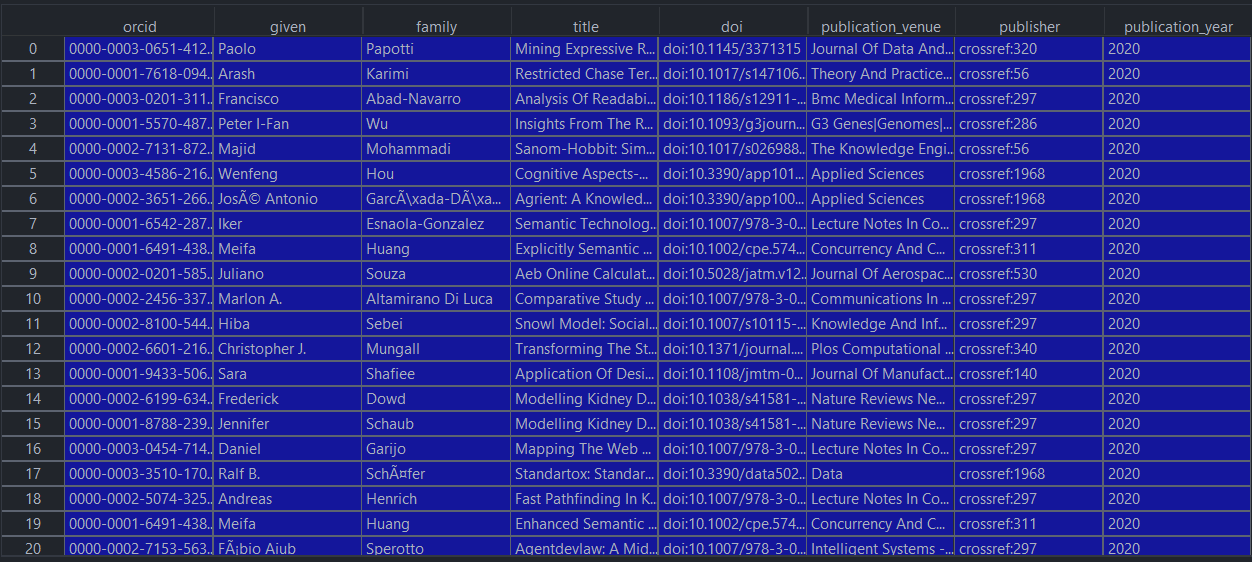

One problem has been found in the development of one specific query, getProceedingsByEvent(self, eventPartialName), because in the dataset provided no events were present. For this reason a fake event has been added to the dataset, in order to test the following query, in which a Filter expression with regex has been used in order to handle the upper/lowercase of the name and the incompleteness of it:

In [ ]:
  def getProceedingsByEvent(self, eventPartialName):
        qry = """
         PREFIX schema:<https://schema.org/>

          SELECT ?publication_venue ?venue_id ?publisher
          WHERE {
              ?s schema:title ?publication_venue.
              ?s schema:VirtualLocation ?venue_id.
              ?s schema:publishedBy ?publisher.
              ?s schema:Event ?event.
              FILTER (REGEX(?event,'""" + str(eventPartialName) + """', "i"))
          }
         """
        df_sparql = get(self.endpointUri, qry, True)
        return df_sparql

One method has been added to the ones required in the UML datamodel, getCitedPublications(self, publicationId), in order to retrieve all the information about the publication cited by another publication, thus the publication cited, the orcid, given name, family name of their authors, the title, publication venue, publisher and publication year of each of them:

In [ ]:
 def getCitedPublications(self, publicationId):
        qry = """
            PREFIX schema: <https://schema.org/>
            SELECT ?cite ?orcid ?given ?family ?title ?publication_venue ?publisher ?publication_year
            WHERE{ 
              {SELECT ?title ?publication_venue ?publication_year ?publisher ?orcid ?cite
               WHERE{ 
                 {SELECT ?cite
                  WHERE{
                       ?y schema:citation ?cite.
                       ?y schema:productID '""" + str(publicationId) + """'
                     }
                 }
                     ?x schema:citation ?cite.
                     ?x schema:title ?title.
                     ?x schema:isPartOf ?publication_venue.
                     ?x schema:datePublished ?publication_year.
                     ?x schema:publishedBy ?publisher.
                     ?x schema:creator ?orcid
                }
        
                ?x schema:creator ?orcid.
                ?x schema:givenName ?given.
                ?x schema:familyName ?family
            }"""
        df_sparql = get(self.endpointUri, qry, True)
        return df_sparql

### Generic Query Processor

The aim of the Generic Query Processor is to gather information from the dataframes obtained by the Triplestore Query Processor and the Relational Query Processor and use it to create and return python objects through the classes which have been defined at the beginning of the work. 
First of all, the Generic Query Processor has only one attribute: *queryProcessor*. It contains the list of QueryProcessor objects to involve when one of the methods is executed. 

In [ ]:
class GenericQueryProcessor:
    def __init__(self, queryProcessor):
        self.queryProcessor = list(queryProcessor)

The first two methods are related to the management of the list queryProcessor: *cleanQueryProcessors* cleans the list from all the QueryProcessor objects it includes, while *addQueryProcessor* appends the input QueryProcessor object to the list. A boolean is returned to make sure that the operation has been successful. 

In [ ]:
def cleanQueryProcessors(self):
    self.queryProcessor.clear()
    if len(self.queryProcessor) == 0:
        return True
    else:
        return False

def addQueryProcessor(self, QueryProcessor):
    length = len(self.queryProcessor)
    self.queryProcessor.append(QueryProcessor)
    if len(self.queryProcessor) == (length + 1):
        return True
    else:
        return False

Every time a *get* method is executed, it will call the related method on all the QueryProcessor objects included in the variable queryProcessor, before combining the results and returning the requested object. The algorithm for the execution of the *get* methods is the same, adapted to every query according to the type of object which needs to be created and thus to the parameters which must be taken from the dataframe (resulting by the union of the two resulting by the Relational Query Processor and the Triplestore Query Processor), stored in variables and provided as input to the constructor of the python objects. 
Firstly, the method takes the dataframes obtained by the execution of the method (in this case, to *getPublicationsPublishedInYear*) in the query processors included in the variable *queryProcessor* (in the example, *trp_qp* is the Triplestore Query Processor and *rel_qp* represents the Relational Query Processor). Then, the dataframes are united, cleaned by removing the duplicates, and sorted (in this case, according to the column "publication_year"). 
The resulting list is thus created and the iteration over the rows of the dataframe begins: every row contains all the information related to a publication and the specific values corresponding to the needed parameters are saved inside variables through the access to the columns. 
When a parameter doesn't consist of a unique value, as in the case of the authors and the cited publications, additional methods are called.
Finally, the python object is created, appended to a list after being converted into a string through the additional method *.__str__()* and the resulting list is returned. 

In [ ]:
def getPublicationsPublishedInYear(self, year):
    graph_year = trp_qp.getPublicationsPublishedInYear(year)
    rel_year = rel_qp.getPublicationsPublishedInYear(year)  
    df_union = concat([graph_year, rel_year], ignore_index=True)
    df_union_no_dupl = df_union.drop_duplicates()
    df_union_sorted = df_union_no_dupl.sort_values("publication_year")
    pub_list = list()

    for row_idx, row in df_union_sorted.iterrows():
        identifier = row["doi"]
        publicationYear = row["publication_year"]
        title = row["title"]
        publicationVenue = row["publication_venue"]
        authors = GenericQueryProcessor.getAuthors(identifier)           
        cites_list = GenericQueryProcessor.getCitation(identifier)
        pub = Publication(identifier, publicationYear, title, cites_list, authors, publicationVenue)
        pub_list.append(pub.__str__())

    return '\n'.join(pub_list)

*getAuthors* and *getCitation* have been added to the Generic Query Processor, besides the ones requested, to simplify the gathering of information. Using the existing methods, such as *getPublicationAuthors*, was not possible because it returns python objects which can't be used as input parameters of another python object. In the case of the authors, we didn't need a list of Person objects, as the one returned by the method *getPublicationAuthors*, but we needed a collection of strings which could anyway include the information related to the authors. 

In [ ]:
def getAuthors(identifier):
    graph_au = trp_qp.getPublicationAuthors(identifier)
    rel_au = rel_qp.getPublicationAuthors(identifier) 
    df_au = concat([graph_au, rel_au], ignore_index=True)
    df_au_no_dupl = df_au.drop_duplicates()
    authors = set()

    for row_idx, row in df_au_no_dupl.iterrows():
        orcid = row["orcid"]
        givenName = row["given"]
        familyName = row["family"]
        author = str(orcid) + ", " + str(givenName) + ", " + str(familyName)
        authors.add(author)

    return authors

The process is the same as the one described for the method *getPublicationsPublishedInYear*, but instead of creating a python object, a set of strings is returned by the *getAuthors* method, and a list of strings is returned by the *getCitation* method. 

In [ ]:
def getCitation(identifier): 
    graph_cite = trp_qp.getCitedOfPublication(identifier)
    rel_cite = rel_qp.getCitedOfPublication(identifier)  
    df_cite = concat([graph_cite, rel_cite], ignore_index=True)
    df_cite_no_dupl = df_cite.drop_duplicates()
    cites_list = []

    for row_idx, row in rel_cite.iterrows():
        identifier = row["doi"]
        publicationYear = row["publication_year"]
        title = row["title"]
        publicationVenue = row["publication_venue"]
        authors = GenericQueryProcessor.getAuthors(identifier)           
        cited_pub = str(identifier) + '; publication year: ' + str(publicationYear) + '; title: ' + str(title) + '; authors: ' + str(authors) + '; publication venue: '  + str(publicationVenue) + '.'
        cites_list.append(cited_pub)
        
    return cites_list

In order to interact with the Generic Query Processor, for example asking for a list of the publications (Publication objects) published in a specific year, the user needs to call the method of the class Generic Query Processor providing the requested parameter(s):

In [ ]:
generic = GenericQueryProcessor([rel_qp, trp_qp])

#Syntax
#print(generic.method(parameter))

print(generic.getPublicationsPublishedInYear(2020))

The output would be the following:

## Descriptive Statistics

## Statements of Responsibility